# Исследовательская тетрадка по прогнозу пополнений банкоматов моделями autoarima и скользящим окном

In [130]:
%load_ext autoreload

import os
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
from plotly import express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_absolute_error

import pmdarima

from bank_schedule import data as bsd
from bank_schedule import forecast

from bank_schedule.constants import (
    CENTER_LAT,
    CENTER_LON,
    RAW_DATA_FOLDER,
    INTERIM_DATA_FOLDER
)

## Читаем данные

In [2]:
loader = bsd.Data(RAW_DATA_FOLDER)

in_df = loader.get_money_in()
start_df = loader.get_money_start()
geo_df = loader.get_geo_TIDS()

display(in_df.head())
print(in_df.info())

display(start_df.head())
print(start_df.info())

display(geo_df.head())
print(geo_df.info())

,date,TID,money_in
0,2022-09-01,406136,90000
1,2022-09-01,406139,103000
2,2022-09-01,406145,143000
3,2022-09-01,406148,50000
4,2022-09-01,406180,96000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148330 entries, 0 to 148329
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      148330 non-null  datetime64[ns]
 1   TID       148330 non-null  int64         
 2   money_in  148330 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 3.4 MB
None


,TID,money
0,406136,160000
1,406139,387000
2,406145,287000
3,406148,355000
4,406180,597000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TID     1630 non-null   int64
 1   money   1630 non-null   int64
dtypes: int64(2)
memory usage: 25.6 KB
None


,TID,longitude,latitude
0,692835,37.646257,55.742062
1,698656,37.666136,55.731231
2,686168,37.675027,55.727031
3,679671,37.669706,55.706824
4,682180,37.596399,55.711151


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TID        1630 non-null   int64  
 1   longitude  1630 non-null   float64
 2   latitude   1630 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 38.3 KB
None


In [3]:
print('Всего банкоматов:', in_df['TID'].unique().shape[0])

Всего банкоматов: 1630


In [4]:
money_in_geo_mean = in_df.groupby('TID')['money_in'].mean().round(2).reset_index()
money_in_geo_median = in_df.groupby('TID')['money_in'].median().round(2).reset_index()
money_in_geo_sum = in_df.groupby('TID')['money_in'].sum().round(2).reset_index()

## Гео визуализация income

In [5]:
for agg_df, title in zip([money_in_geo_mean, money_in_geo_median, money_in_geo_sum],
                         ['money_in_mean', 'money_in_median', 'money_in_sum']):

    fig = px.scatter_mapbox(geo_df.merge(agg_df),
                            lat='latitude',
                            lon='longitude',
                            color='money_in',
                            hover_name=geo_df['TID'],
                            center=dict(lat=CENTER_LAT, lon=CENTER_LON),
                            range_color=[agg_df['money_in'].min(),
                                        agg_df['money_in'].max()],
                            color_continuous_scale='dense',
                            height=800,
                            width=800,
                            opacity=.9,
                            mapbox_style="carto-positron",
                            title=title)
    fig.write_html(os.path.join(INTERIM_DATA_FOLDER, f"{title}.html"))
    fig.show()

In [6]:
for agg_df, title in zip([money_in_geo_sum],
                         ['money_in_sum']):

    fig = px.scatter_mapbox(geo_df.merge(agg_df),
                            lat='latitude',
                            lon='longitude',
                            color='money_in',
                            hover_name=geo_df['TID'],
                            center=dict(lat=CENTER_LAT, lon=CENTER_LON),
                            range_color=[agg_df['money_in'].quantile(.05),
                                        agg_df['money_in'].quantile(.95)],
                            color_continuous_scale='dense',
                            height=800,
                            width=800,
                            opacity=.9,
                            mapbox_style="carto-positron",
                            title=title)
    fig.write_html(os.path.join(INTERIM_DATA_FOLDER, f"{title}.html"))
    fig.show()

## timeseries визуализация income

In [7]:
tids_list = [
    # 605329,
    # 634558,
    658916,
    686140
    ]

df = in_df[in_df['TID'].isin(tids_list)]
fig = px.line(df,
              x='date',
              y='money_in',
              color='TID',
              title='Income',
              height=500,
              width=1200)
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20))
fig.show()

## Исследования трендов, сезонностей etc

,TID,money_in
date,,
2022-09-01,658916,40000
2022-09-02,658916,25000
2022-09-03,658916,0
2022-09-04,658916,48000
2022-09-05,658916,40000
...,...,...
2022-11-26,658916,23000
2022-11-27,658916,38000
2022-11-28,658916,28000


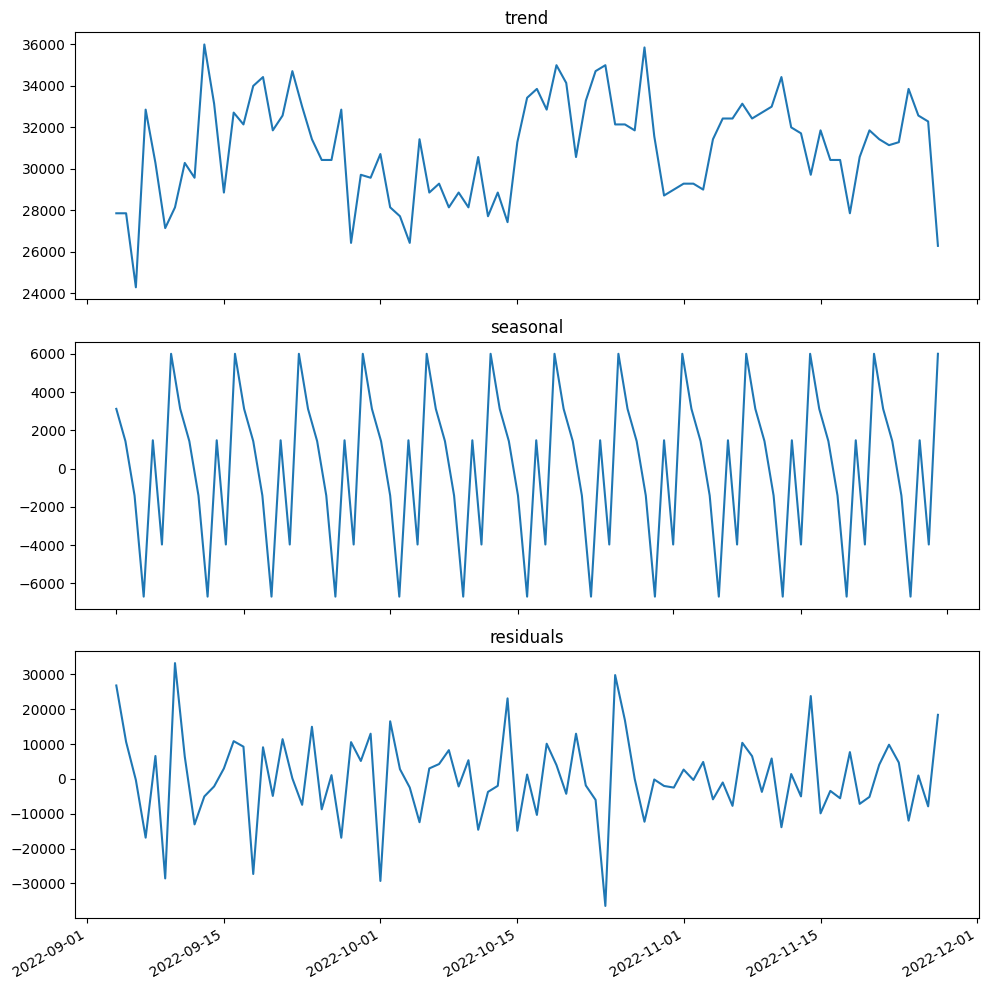

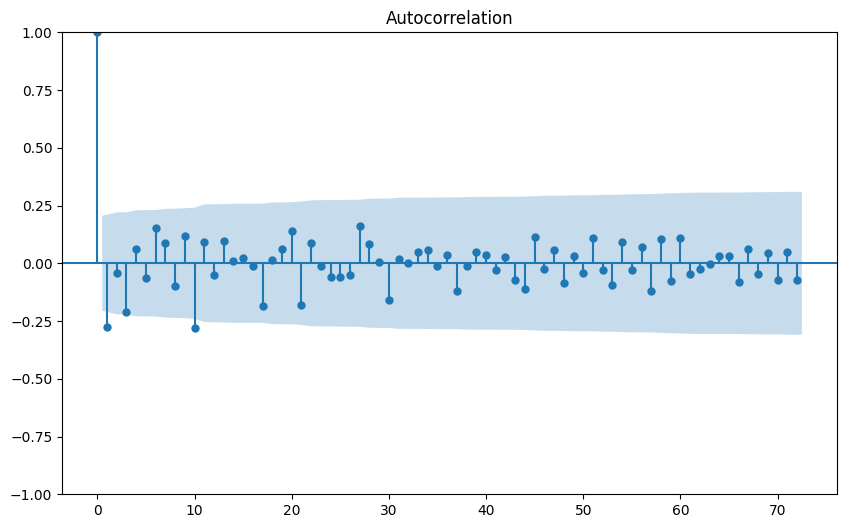

In [8]:
tids_list = [
    658916
    ]

df = in_df[in_df['TID'].isin(tids_list)]
df.set_index('date', inplace=True)
display(df)

decompose_additive = seasonal_decompose(df['money_in'], model='additive')
fig, axs  = plt.subplots(nrows=3, ncols=1, figsize=(10,10))

axs[0].set_title('trend')
axs[0].plot(decompose_additive.trend)

axs[1].set_title('seasonal')
axs[1].plot(decompose_additive.seasonal)

axs[2].set_title('residuals')
axs[2].plot(decompose_additive.resid)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
acf = plot_acf(df['money_in'], lags=72, ax=ax)

## Сравнение autoarima и rolling_window

In [76]:
from typing import Dict

def get_model_score(in_df: pd.DataFrame,
                    models: Dict[str, object],
                    n_periods: int) -> pd.DataFrame:

    scores_tid = {}

    all_tids = in_df['TID'].unique()

    for tid in tqdm(all_tids, total=all_tids.shape[0]):
        df = in_df[in_df['TID'] == tid]

        train_tgts = df['money_in'].values[:-n_periods]
        test_tgts = df['money_in'].values[-n_periods:]

        models[tid].fit(train_tgts)
        predictions = models[tid].predict(n_periods=n_periods)
        scores_tid[tid] = mean_absolute_error(test_tgts, predictions)

    scores_df = pd.DataFrame.from_dict(scores_tid, orient='index').reset_index()
    scores_df.columns = ['TID', 'mae']

    return scores_df, models


def get_arima_models(in_df: pd.DataFrame,
                     rows_limit: int=61) -> Dict[str, object]:

    models = {}

    all_tids = in_df['TID'].unique()

    for tid in tqdm(all_tids, total=all_tids.shape[0]):
        df = in_df[in_df['TID'] == tid]
        models[tid] = pmdarima.arima.auto_arima(df['money_in'].iloc[:rows_limit],
                                                error_action="ignore")

    return models

In [77]:
arima_models = get_arima_models(in_df)

100%|██████████| 1630/1630 [09:42<00:00,  2.80it/s]


100%|██████████| 1630/1630 [00:37<00:00, 43.10it/s]


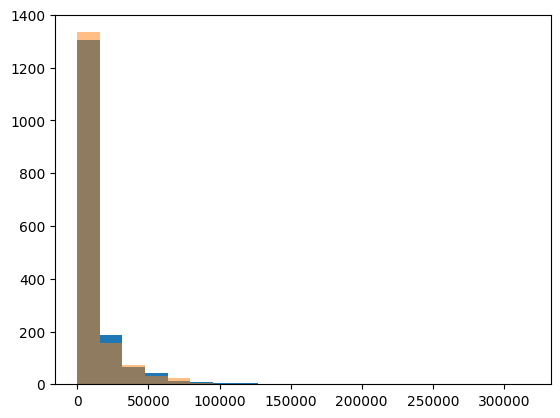

1
Simple models MAE:  18211800.0
ARIMA models MAE:  19834438.85


100%|██████████| 1630/1630 [00:39<00:00, 41.34it/s]


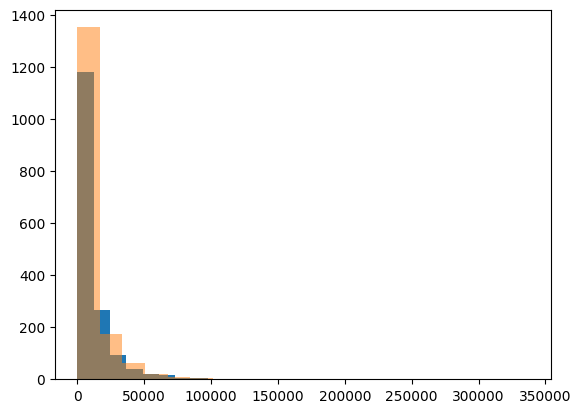

2
Simple models MAE:  18468900.0
ARIMA models MAE:  19527169.58


100%|██████████| 1630/1630 [00:37<00:00, 43.73it/s]


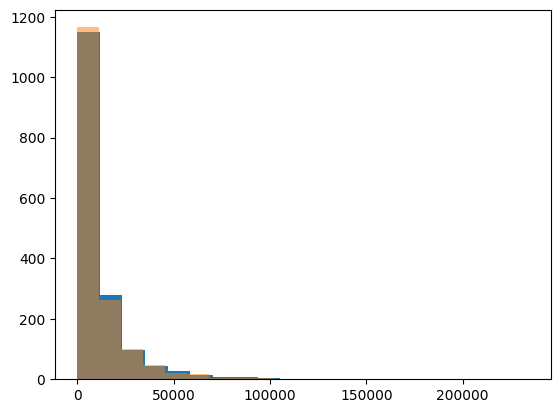

5
Simple models MAE:  19549740.0
ARIMA models MAE:  20840932.25


100%|██████████| 1630/1630 [00:38<00:00, 42.85it/s]


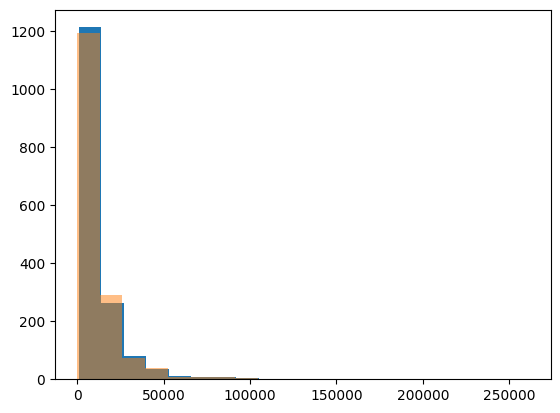

10
Simple models MAE:  20633600.0
ARIMA models MAE:  21388442.78


100%|██████████| 1630/1630 [00:39<00:00, 40.83it/s]


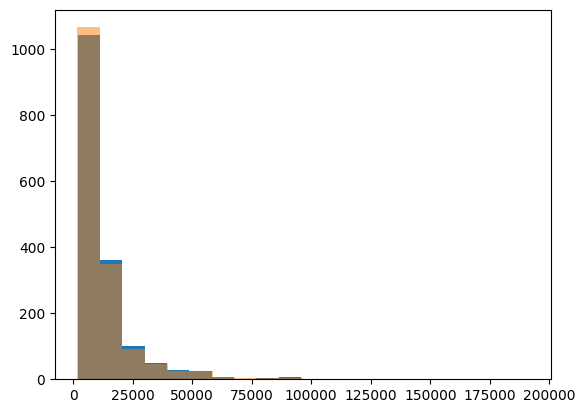

30
Simple models MAE:  20833493.33
ARIMA models MAE:  21313526.74


In [127]:
for n_periods in [1, 2, 5, 10, 30]:

    simple_models = {tid: forecast.SimpleRollingForecast(window=10, alpha=0) for tid in in_df['TID'].unique()}
    
    simple_models_score, _ = get_model_score(in_df, simple_models, n_periods=n_periods)

    arima_models_score, _ = get_model_score(in_df, arima_models, n_periods=n_periods)

    plt.hist(arima_models_score['mae'], bins=20)
    plt.hist(simple_models_score['mae'], bins=20, alpha=.5)
    plt.show()

    print(n_periods)
    print('Simple models MAE: ', simple_models_score['mae'].sum().round(2))
    print('ARIMA models MAE: ', arima_models_score['mae'].sum().round(2))

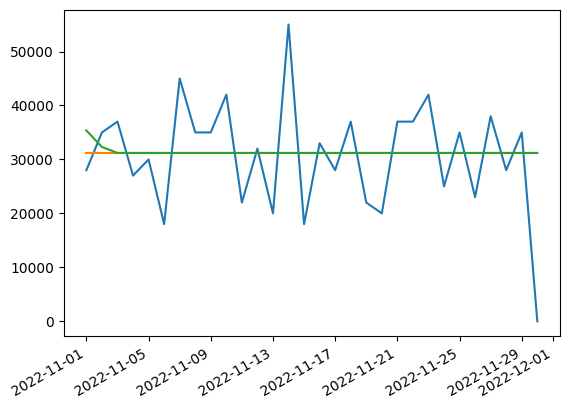

In [157]:
%autoreload 2
tids_list = [
    658916
    ]

df = in_df[in_df['TID'].isin(tids_list)]
df.set_index('date', inplace=True)

n_periods = 30
train_tgts = df['money_in'][:-n_periods]
test_tgts = df['money_in'][-n_periods:]

model1 = forecast.SimpleRollingForecast(window=30, alpha=0.1)
model2 = pmdarima.arima.auto_arima(train_tgts,
                                  start_p=1,
                                  start_q=1,
                                  max_p=30,
                                  max_q=30,
                                  error_action="ignore")

fig, ax = plt.subplots()
ax.plot(test_tgts)

for model in [model1, model2]:
    model.fit(train_tgts)
    predicted = pd.Series(model.predict(n_periods=n_periods))
    predicted.index = test_tgts.index
    ax.plot(predicted)

fig.autofmt_xdate()